In [618]:
#importing Packages
import pandas as pd
import numpy as np
import math
import datetime
import seaborn as sns
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline



In [619]:
#importing clean datasets
normal_transactions=pd.read_csv('clean_data/normal_transaction.csv')
offer_success=pd.read_csv('clean_data/offer_success.csv')
waste_offer_transaction=pd.read_csv('clean_data/waste_offer_transaction.csv')
waste_offer=pd.read_csv('clean_data/waste_offer.csv')
profile_amount=pd.read_csv('clean_data/profile_amount.csv')
transaction_df=pd.read_csv('clean_data/transaction_df.csv')

In [620]:
normal_transactions=normal_transactions.drop(columns=['Unnamed: 0'])
offer_success=offer_success.drop(columns=['Unnamed: 0'])
waste_offer=waste_offer.drop(columns=['Unnamed: 0'])
waste_offer_transaction=waste_offer_transaction.drop(columns=['Unnamed: 0'])
profile_amount=profile_amount.drop(columns=['Unnamed: 0'])
transaction_df=transaction_df.drop(columns=['Unnamed: 0'])

## Let's Start with Relevant Business Question to Answer with help of this project
* Most successful kinds of offers in BOGO, Discount and Informational, since multiple types of each offer were tried(Generated Maxiumum Revenue)
* Which Offer has the best Conversion Ratio ( Ratio of Redeemed by Sent)
* Customers who are not at all affected by offers and should be stop sending offers
* Which month has the most New Customer registrations in a year?
* Who are the Most Accurate Starbucks Customer by (AGE and GENDER)

In [621]:
offer_details=offer_success.groupby(['offer_id','offer_type'])['amount'].sum()
offer_details=offer_details.reset_index(name='amount')

In [622]:
offer_details.head(10)

,offer_id,offer_type,amount
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,35044.53
1,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,73565.84
2,2906b810c7d4411798c6938adc9daaa5,discount,48640.79
3,3f207df678b143eea3cee63160fa8bed,informational,30843.90
4,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,68318.55
5,5a8bc65990b245e5a138643cd4eb9837,informational,42512.31
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,43806.18
7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,67900.38
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,69830.07
9,fafdcd668e3743c1bb461111dcafc2a4,discount,76182.11


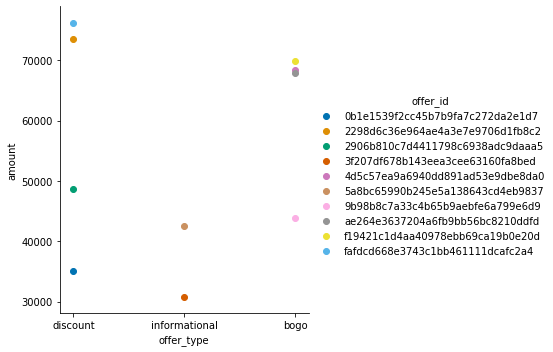

In [623]:
g=sns.FacetGrid(data=offer_details, hue='offer_id',height=5, palette='colorblind')
g.map(plt.scatter,'offer_type', 'amount')
g.add_legend();

### ** RESULT ** Most Succesful Offer Id's in Each Offer type:
* **Discount**: fafdcd668e3743c1bb461111dcafc2a4
* **Bogo**: f19421c1d4aa40978ebb69ca19b0e20d
* **Informational**: 5a8bc65990b245e5a138643cd4eb9837

In [624]:
offer_success.groupby('offer_type')['offer_completed'].count()
#offer_success.head()

offer_type
bogo             11827
discount         10340
informational     6420
Name: offer_completed, dtype: int64

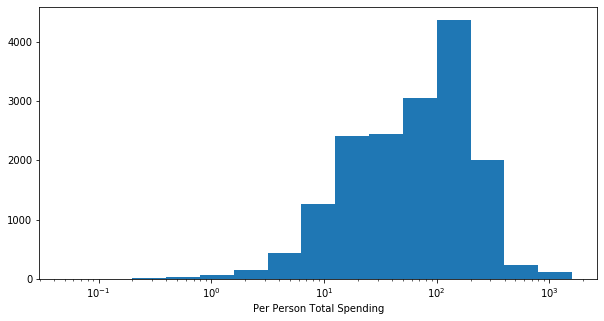

In [625]:
plt.figure(figsize=(10,5))
bins= 10 ** np.arange(-1.3,3.2+0.3,0.3)
#ticks=[ 1, 100, 300]
#labels={'{}'.format(v) for v in ticks}
plt.hist(data=profile_amount, x='amount', bins=bins);
plt.xscale('log')
#plt.xticks(ticks,labels)
plt.xlabel('Per Person Total Spending');

### ** Result ** The Median Amount Spent by People on Starbucks is USD 72.41 but the majority of people have spend around USD 100 -250 since being a member

In [626]:
profile_amount['age_range']=pd.cut((profile_amount.dropna(subset=['age'])['age']).astype('int'),bins=10, precision=0)

In [627]:
profile_amount.head()

,gender,age,person,became_member_on,income,amount,age_range
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,20.40,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,77.01,"(51.0, 60.0]"
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,14.30,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,159.27,"(68.0, 76.0]"
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,4.65,NaN


In [628]:
best_customers= profile_amount.groupby(['age_range','gender'])['amount'].sum()
best_customers=best_customers.reset_index(name='amount')

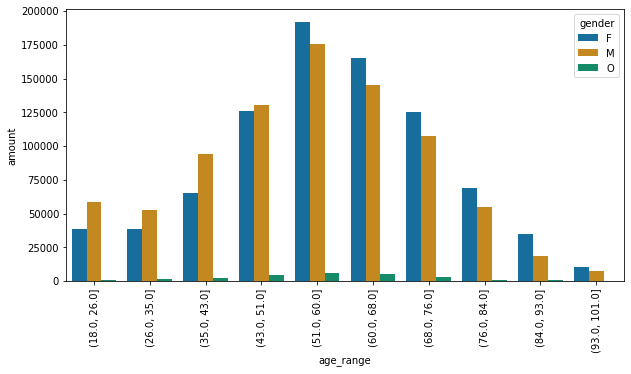

In [629]:
plt.figure(figsize=[10,5])
sns.barplot(x='age_range',y='amount', data=best_customers, hue='gender', palette='colorblind', ci=0)
plt.xticks(rotation=90);

### ** RESULT ** This Visualisation Clearly Shows that
* 'FEMALE' of 51-60 years of age are the most spending customers of starbucks.
* 51-60 years of age are the most spending Male customers of starbucks.

In [775]:
profile=profile_amount.drop(columns=['amount'])
offer_success=pd.merge(offer_success,profile, on=['person'], how='left')

In [776]:
offer_success['type']='success'

In [783]:
waste_offer['type']='fail'

In [784]:
all_offers_df= offer_success.append(waste_offer)

In [785]:
a=all_offers_df.groupby('person')['type'].count()
a=a.reset_index(name='total')

In [786]:
b = all_offers_df[all_offers_df['type']=='fail'].groupby('person')['type'].count()
b=b.reset_index(name='failed')

In [787]:
a= a.merge(b, on=['person'], how='left').fillna(0)

In [788]:
## Creating a Offer failure percentage column
a['fail_percentage']=(a['failed']/a['total'])*100

In [792]:
a.head(10)

,person,total,failed,fail_percentage
0,0009655768c64bdeb2e877511632db8f,4,1.0,25.000000
1,00116118485d4dfda04fdbaba9a87b5c,1,1.0,100.000000
2,0011e0d4e6b944f998e987f904e8c1e5,3,0.0,0.000000
3,0020c2b971eb4e9188eac86d93036a77,4,2.0,50.000000
4,0020ccbbb6d84e358d3414a3ff76cffd,4,0.0,0.000000
5,003d66b6608740288d6cc97a6903f4f0,4,2.0,50.000000
6,00426fe3ffde4c6b9cb9ad6d077a13ea,4,2.0,50.000000
7,004b041fbfe44859945daa2c7f79ee64,3,1.0,33.333333
8,004c5799adbf42868b9cff0396190900,5,3.0,60.000000
9,005500a7188546ff8a767329a2f7c76a,3,3.0,100.000000


In [789]:
# Creating list of all the Id's of User who responded perfectly to all the offers
all_offers_success=(a[a['fail_percentage']==0]['person']).to_list()

In [790]:
# Creating list of all the Id's of User who didn't respond to any offer at all
all_offers_failed=(a[a['fail_percentage']==100]['person']).to_list()

   ### ** RESULT ** 'all_offers_success' & 'all_offer_failed' is the list of user accounts on which the company needs to take strategic decisions to continue sending the offers of stop

In [642]:
params=['amount', 'difficulty','time_validity', 'time_view', 'reward', 'income']

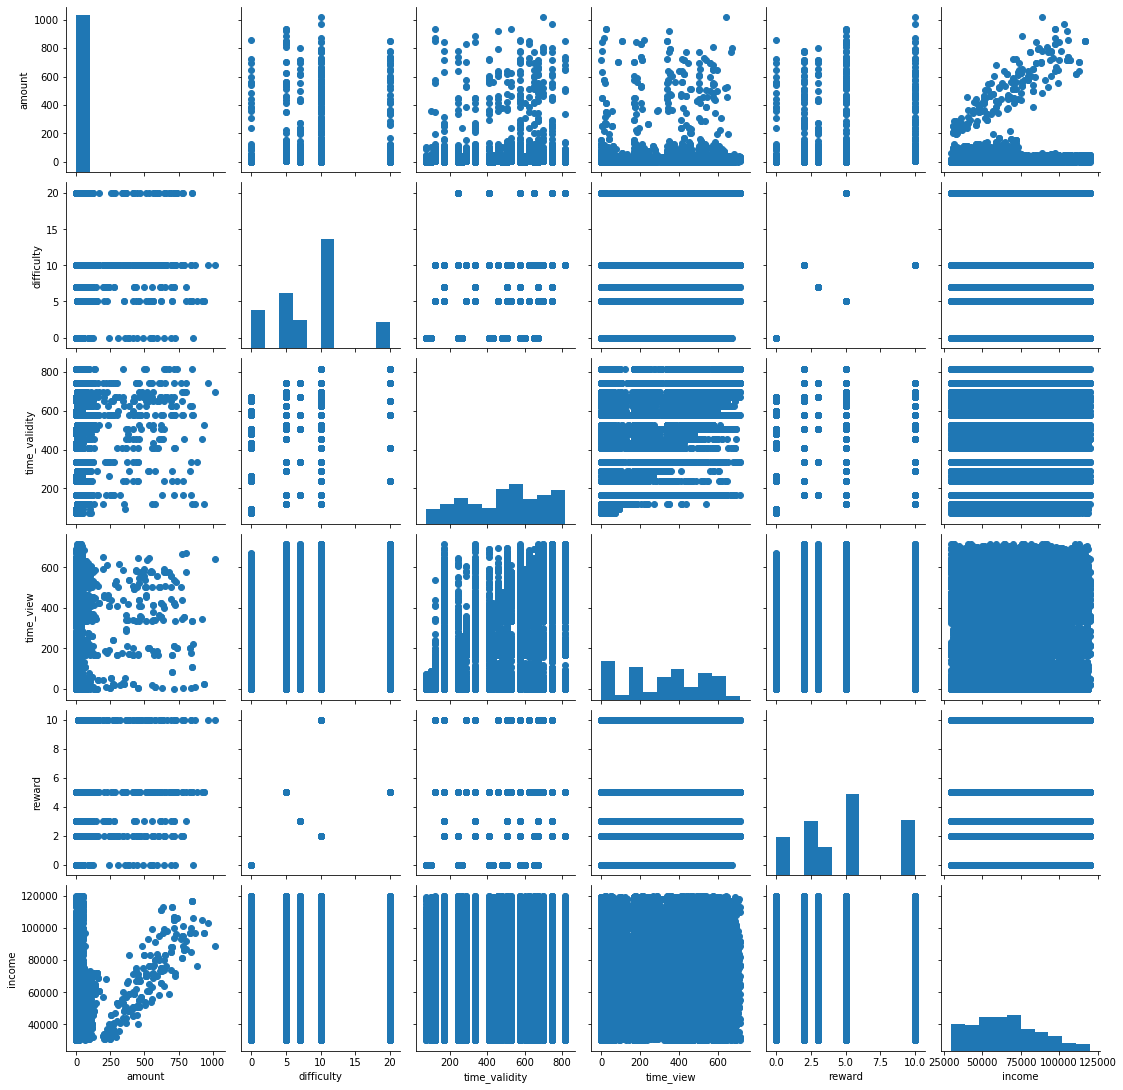

In [643]:
g= sns.PairGrid(data=all_offers_df, vars=params)
g= g.map_offdiag(plt.scatter);
g.map_diag(plt.hist);

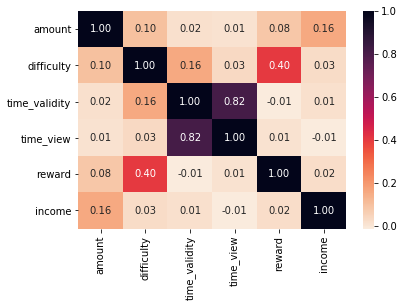

In [644]:
sns.heatmap(all_offers_df[params].corr(), cmap='rocket_r', annot=True, fmt='0.2f');

## Using ML Models

In [645]:
all_offers_df.isna().sum()

channel_email           0
channel_mobile          0
channel_social          0
channel_web             0
difficulty              0
duration                0
least_pay               0
offer_completed         0
offer_id                0
offer_received          0
offer_type              0
offer_view              0
person                  0
reward                  0
time_completed      24983
time_start              0
time_view           14153
total                   0
time_validity           0
amount              24983
type                    0
gender               7739
age                  7739
became_member_on        0
income               7739
age_range            7739
dtype: int64

In [646]:
all_offers_df['offer_view']=all_offers_df['offer_view'].replace(2,1)
all_offers_df['offer_completed']=all_offers_df['offer_completed'].replace(4,1)

In [647]:
all_offers_df['time_view']=all_offers_df['time_view'].fillna(0)

In [648]:
test_sub=profile_amount.drop(columns=['amount'])

In [653]:
test=all_offers_df.drop(columns=['channel_email', 'channel_mobile', 'channel_social', 'channel_web',
                                                                                     'time_completed','time_validity'
                                                                                     ,'total'
                                                                                     ,'time_start','offer_received'
                                                                                     ,'offer_completed', 'person'])

In [654]:
test.head()

,difficulty,duration,least_pay,offer_id,offer_type,offer_view,reward,time_view,amount,type,gender,age,became_member_on,income,age_range
0,5.0,168.0,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,1.0,5.0,6.0,19.89,success,F,75.0,2017-05-09,100000.0,"(68.0, 76.0]"
1,5.0,120.0,5.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo,1.0,5.0,0.0,9.54,success,M,65.0,2018-02-09,53000.0,"(60.0, 68.0]"
2,20.0,240.0,15.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,1.0,5.0,30.0,339.69,success,F,88.0,2017-05-18,53000.0,"(84.0, 93.0]"
3,10.0,240.0,8.0,fafdcd668e3743c1bb461111dcafc2a4,discount,1.0,2.0,18.0,28.29,success,M,42.0,2013-08-11,69000.0,"(35.0, 43.0]"
4,20.0,240.0,15.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,1.0,5.0,30.0,27.23,success,F,56.0,2018-04-28,88000.0,"(51.0, 60.0]"


In [655]:
test.dropna(subset=['gender','age','income','amount'], inplace=True)

In [656]:
test['amount']=test['amount'].fillna(0)
test=test.drop(columns=['age_range','offer_type'])

In [657]:
test['Female'] = test['gender'].apply(lambda x: 1 if 'F' in x else 0)
test['Male'] = test['gender'].apply(lambda x: 1 if 'M' in x else 0)
test['Others'] = test['gender'].apply(lambda x: 1 if 'O' in x else 0)

In [658]:
test.head()

,difficulty,duration,least_pay,offer_id,offer_view,reward,time_view,amount,type,gender,age,became_member_on,income,Female,Male,Others
0,5.0,168.0,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,5.0,6.0,19.89,success,F,75.0,2017-05-09,100000.0,1,0,0
1,5.0,120.0,5.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0,5.0,0.0,9.54,success,M,65.0,2018-02-09,53000.0,0,1,0
2,20.0,240.0,15.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,5.0,30.0,339.69,success,F,88.0,2017-05-18,53000.0,1,0,0
3,10.0,240.0,8.0,fafdcd668e3743c1bb461111dcafc2a4,1.0,2.0,18.0,28.29,success,M,42.0,2013-08-11,69000.0,0,1,0
4,20.0,240.0,15.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,5.0,30.0,27.23,success,F,56.0,2018-04-28,88000.0,1,0,0


In [659]:
x= test.loc[:,['difficulty','duration','offer_id','reward','Female','offer_view','Male','Others','age','income']]
y= test.loc[:,['type']]

In [660]:
## Applying Encoding to Categorical Variables
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [2])], remainder='passthrough')

x = np.array(ct.fit_transform(x))


In [661]:
## Encoding Dependent Variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

/Users/aadhar/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [662]:
print(y)

[1 1 1 ... 0 0 0]


In [663]:
## Splitting into Training and test Set

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

In [664]:
## Applying Feature Scaling

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [665]:
# Using Random Forest Regressor Model
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [666]:
#Predicting y of test set
y_pred= classifier.predict(x_test)
# Forming the Confusion Matrix and Accuracy Score of Test Set
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[1328 1448]
 [1088 5695]]


0.7347002824563239

In [667]:
# printing the classification report
target_names = ['success','fail']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     success       0.55      0.48      0.51      2776
        fail       0.80      0.84      0.82      6783

    accuracy                           0.73      9559
   macro avg       0.67      0.66      0.66      9559
weighted avg       0.73      0.73      0.73      9559



In [668]:
offer_success.shape

(28587, 21)

## ML Algorithm without Inputs of User View time or User View State

In [669]:
x= test.loc[:,['difficulty','duration','offer_id','reward','Female','Male','Others','age','income']]
y= test.loc[:,['type']]

In [670]:
## Applying Encoding to Categorical Variables
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [2])], remainder='passthrough')

x = np.array(ct.fit_transform(x))


In [671]:
## Encoding Dependent Variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

/Users/aadhar/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [672]:
print(y)

[1 1 1 ... 0 0 0]


In [673]:
## Splitting into Training and test Set

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 42)

In [674]:
## Applying Feature Scaling

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [675]:
# Using Random Forest Regressor Model
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [676]:
#Predicting y of test set
y_pred= classifier.predict(x_test)
# Forming the Confusion Matrix and Accuracy Score of Test Set
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[ 898 1878]
 [1544 5239]]


0.6420127628413014

In [677]:
# printing the classification report
target_names = ['success','fail']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     success       0.37      0.32      0.34      2776
        fail       0.74      0.77      0.75      6783

    accuracy                           0.64      9559
   macro avg       0.55      0.55      0.55      9559
weighted avg       0.63      0.64      0.63      9559

